# CZSa 2024 Homework 1

## Instructions

You are allowed to collaborate and to use information from slides, books, internet etc., for solving this homework. HOWEVER, in the final exam, there will be some questions that are very similar to some questions of this homework and/or the next homework. These questions can give ten (10) points in total on the exam. Therefore, it is beneficial for you to understand the answers you provide here.

Deadline 2024-12-16 by email. Please include any code you have written either, separately or as verbatim text in the report. 

Please don't hestitate to ask if something is unclear.

## 1 (3p)
### a) 
Calculate numerically the SNR resulting from quantization of a real signal. For example, you can use the speech recording ```00011.wav``` available in the GitHub repository. Plot the SNR vs the number of bits, e.g., for $\# \rm{bit}s=2,3,4,5,6,7,8$. \
You can use the functions ```quantize```, ```normalize``` and other code pieces from Exercise 1. 

In [2]:
# Libraries and reading the audio file
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile
from scipy import signal
from IPython.display import Audio

audio_file = "00011.wav"
r, a = scipy.io.wavfile.read(audio_file)
a = a.astype("int32")  
# Note that this means we are using 32bit quantization. 
# The original quantization was 16 so we can't get better than that actually (worth keeping in mind in the below experiments).

In [3]:
# Quantization function
def quantize(x, b=4, level_at_zero=False):
    """
    x:             The signal. Assumed to be in the range -1 to 1
    b:             Number of bits. The number of quantization levels is 2^b
    level_at_zero: If True, the first quantization level will be at
                    -1 and the last at -q where q is the quantization step.
                    This means there will be a quantization level in 0.
                    This is the "Q" format standard.
                    If False, the first level will be at -1+q/2 and the
                    last at 1-q/2. This is symmetric.
                    Plot and see the difference if unclear.
    """
    n = 2**b # Number of quantization leveles
    r = 2    # range, i.e. 2 times amplitude

    if level_at_zero:
        o=0
    else:
        o = r/(2*n)

    ql = np.linspace(-1 +o, 1-2/n +o  ,n)
    xq = list(map(lambda v: ql[np.argmin(np.abs(v-ql))], x))

    return xq

# Returns the input normalized so that is in [-1,1]
def normalize(x):
    return 2*(x - np.min(x)) / (np.max(x) - np.min(x))-1, np.max(x),  np.min(x)

# Sets it back to its original range
def de_normalize(x, ma, mi):
    return (x + 1)*(ma-mi)/2 + mi

# Calculating the SNR
def calculate_snr(original_signal, quantized_signal):
    # Power of the original signal
    signal_power = np.mean(original_signal**2)
    
    # Power of the noise (quantization error)
    noise_power = np.mean((original_signal - quantized_signal)**2)
    
    # Calculate SNR in decibels
    snr = 10 * np.log10(signal_power / noise_power)
    
    return snr, (original_signal - quantized_signal)

Why calculating power is sufficient in this case: In the discrete case, when the signal is finite in length, calculating the sum of squared values (energy) is equivalent to computing the mean (power) if you are comparing over the same interval. Both methods provide a valid SNR. In fact, when comparing two signals over the same number of samples, the relative ratio of their energies is the same as the ratio of their powers.

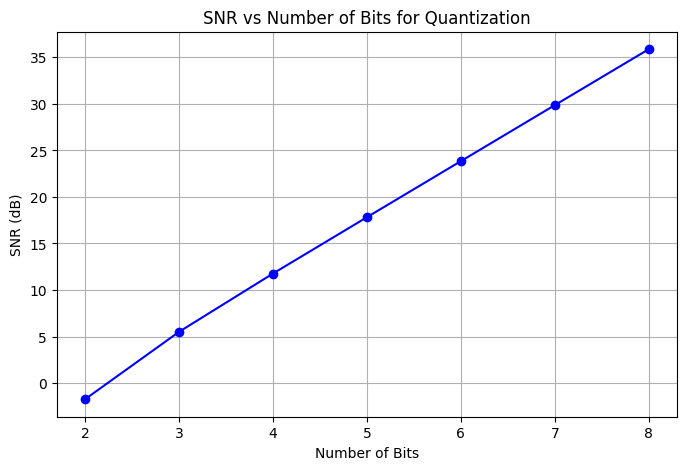

In [4]:
# Bit depths from 2 to 8
bits = np.arange(2, 9)
snr_values = []
err_values = []

# Normalize the signal
a_normalized, ma, mi = normalize(a)

for b in bits:
    # Quantize the normalized signal
    a_quantized = np.array(quantize(a_normalized, b))
    
    # Calculate SNR for the current quantization
    snr, err = calculate_snr(a_normalized, a_quantized)
    snr_values.append(snr)
    err_values.append(err)

# Plotting SNR vs Number of Bits
plt.figure(figsize=(8, 5))
plt.plot(bits, snr_values, marker='o', linestyle='-', color='b')
plt.title('SNR vs Number of Bits for Quantization')
plt.xlabel('Number of Bits')
plt.ylabel('SNR (dB)')
plt.grid(True)
plt.show()

As the number of bits used for quantization increases, the SNR (Signal-to-Noise Ratio) increases because quantization error (or noise) decreases. 

Intuition: More bits → More levels → Smaller quantization steps → Smaller quantization error → Higher SNR.

In [5]:
# Demo of various quantization levels
for b in bits:
   a_quantized = np.array(quantize(a_normalized, b))
   # display(Audio(quantize(a_normalized, b), rate=16000))

### b) 
Compare the plot to the two results for SNR we derived in Lecture 1, i.e., 
\begin{equation}
SNR_{\rm{sine}}=6.02b + 1.67\,\,dB
\end{equation}
and
\begin{equation}
SNR_{\rm{uniform}}=6.02b\,\,dB
\end{equation}
where $SNR_{\rm{sine}}$ and $SNR_{\rm{uniform}}$ refers to the case of a sine signal and a uniformly distributed signal respectively (one example of a uniformly distributed signal is the sawtooth signal [https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sawtooth.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sawtooth.html)). In both formulas, $b$ is the number of bits used for the quantization. For both formulas, the error is assumed to be uniformly distributed in $[-q/2, q/2]$ where $q$ is the quantization step, i.e., the difference of two adjecent quantiztion levels. 

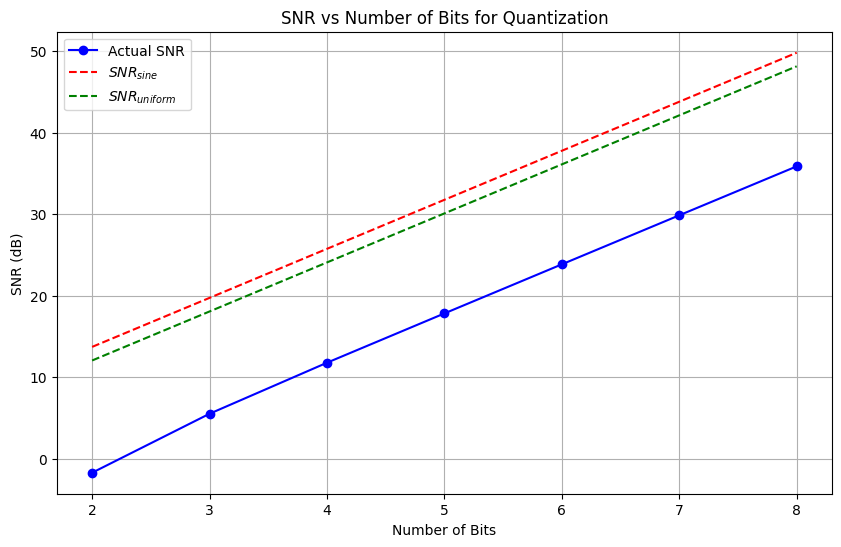

In [6]:
# Theoretical SNR values for sine and uniform signals
snr_sine = 6.02 * bits + 1.67
snr_uniform = 6.02 * bits

plt.figure(figsize=(10, 6))
plt.plot(bits, snr_values, marker='o', linestyle='-', color='b', label='Actual SNR')
plt.plot(bits, snr_sine, linestyle='--', color='r', label='$SNR_{sine}$')
plt.plot(bits, snr_uniform, linestyle='--', color='g', label='$SNR_{uniform}$')

plt.title('SNR vs Number of Bits for Quantization')
plt.xlabel('Number of Bits')
plt.ylabel('SNR (dB)')
plt.grid(True)
plt.legend()

plt.show()

### c)
Analyse how accurate the assumptions for the above two formulas are for the signal you used. The assumptions about uniform distributions can be analaysed for example by plotting histograms. The assumptions about the signal being a pure sine or cosine signal can be checked by calculating DFT and plotting the spectrum.  

Why are the theoretical SNRs higher? 
1. If our signal is not a perfect sine wave, the actual SNR will be lower than predicted by $SNR_{\rm{sine}}$.
2. Similarly, if the signal or the quantization error doesn’t follow a uniform distribution, the actual SNR will deviate from $SNR_{\rm{uniform}}$.

The supporting plots/arguments follow.

Based on the figures below, we can see the error distributions. We observe that the more bits we use, the more uniform the error gets. We can conclude that the finer quantization steps we have, the better is the signal quantized.

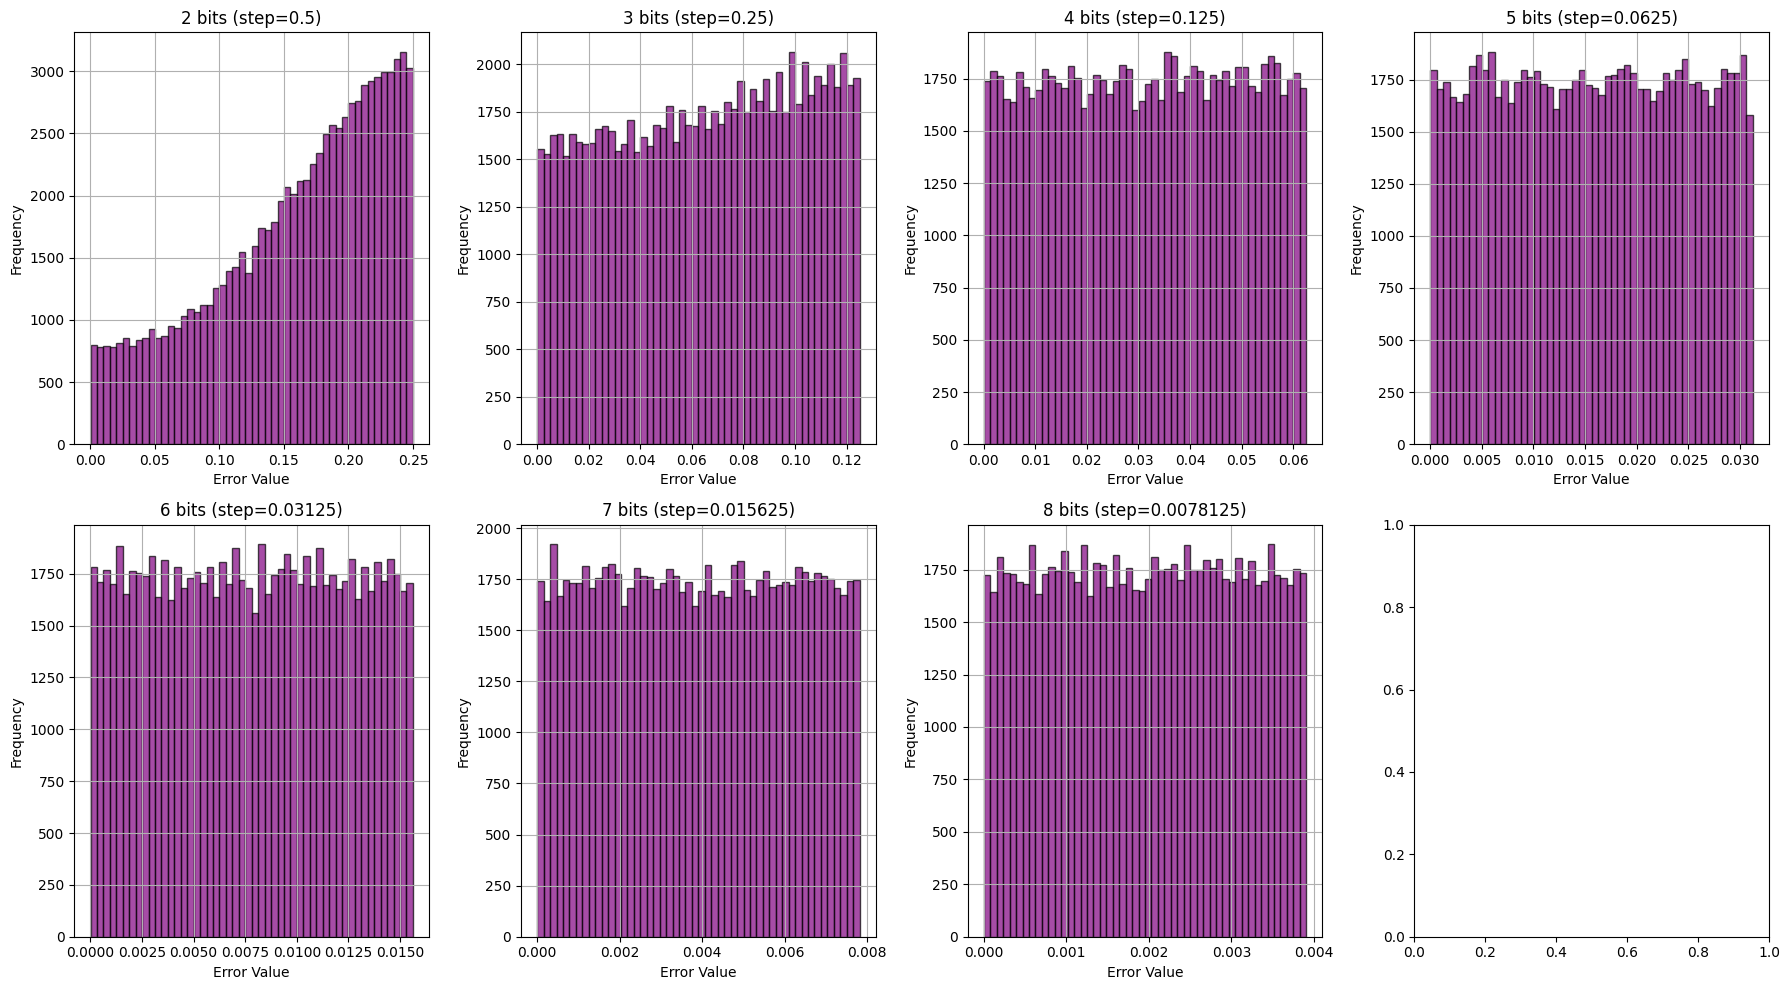

In [7]:
# Assuming err_values is a list where each element corresponds to quantization errors for different bit values
bits_range = range(2, 9)  # Bits from 2 to 8
n_bits = len(bits_range)  # Number of bit values

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))  # 2 rows, 4 columns grid

# Flatten the axes array for easier iteration (since axes is a 2D array with 2x4)
axes = axes.flatten()

# Plot each histogram in a separate subplot
for i, b in enumerate(bits_range):
    axes[i].hist(np.abs(err_values[i]), bins=50, color='purple', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{b} bits (step={2/(2**b)})')
    axes[i].set_xlabel('Error Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

**Question**: Since we can see that with more bits the distribution is more uniform, why the SNR does not increase faster?

Next, we can have a look at the signal in the frequency domain.

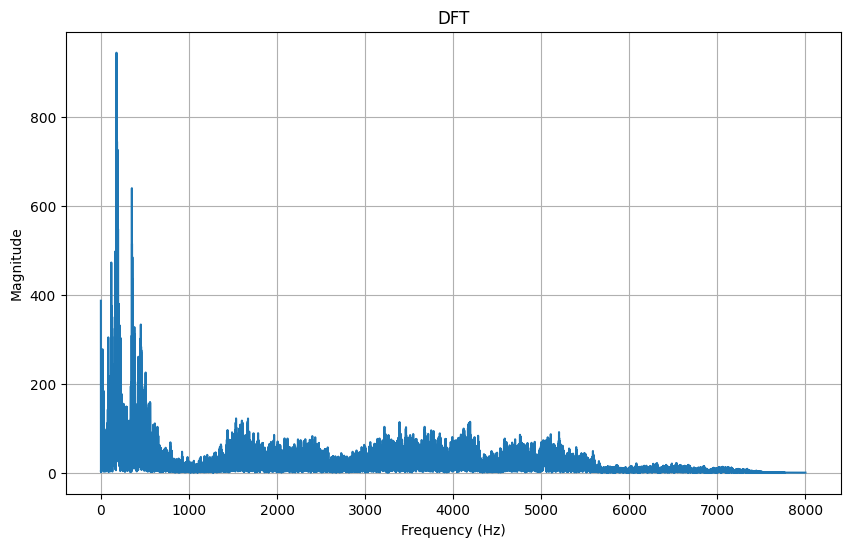

In [8]:
from scipy.fft import fft, fftfreq

# Compute the DFT of the normalized signal
signal_dft = fft(a_normalized)

# Frequency axis
N = len(a_normalized)
sample_rate = 16000  # Assuming a 16kHz sampling rate
freqs = fftfreq(N, 1 / sample_rate)

# Plot the magnitude spectrum
plt.figure(figsize=(10, 6))
plt.plot(freqs[:N//2], np.abs(signal_dft)[:N//2])
plt.title('DFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

## 2 (2p)
Recall from Lecture 1 that if a signal is sampled with sampling frequency $F_s$ and before sampling contained only frequencies below $F_s/2$ then it can be reconstructed according to
\begin{equation}
f(t)=\sum_{n=-\infty}^{\infty} f\left(\frac{n}{F_s} \right )\frac{\sin(tF_s\pi -n\pi)}{tF_s\pi -n\pi}\quad (1),
\end{equation}
where $f\left(\frac{n}{F_s} \right )= f\left(nT_s \right )$ is the signal values at the sampling points ($F_s=1/T_s$).
### a)
Downsample (decimate) the signal used before with a factor 4 using the appropriate anti-aliasing filter. That is, if your original signal is in 16KHz (and accordingly has already been filtered so that it only contains frequencies below 8KHz) you

1. Create a low pass filter with cut off frequency 2KHz (you can use code snippets from exercise 4 based on ```scicpy.signal``` for this) and send the signal through the filter. Denote the obtained signal $x[n]$.
2. Discard 3 out of four samples, i.e., you keep every fourth sample of the signal. This can be written as $x_{\rm{d}}[n]=x[4n]$ where the left hand side is the downsampled signal and the right hand side is the original signal after anti-alias filtering. 

Using the ``00011.wav``, we know the sampling rate is 16 kHz and from figure below, we can see that the frequencies are not higher than 8 kHz.

Higher-order filters tend to have a steeper cutoff, meaning they more sharply remove frequencies above the cutoff point. However, higher-order filters also introduce more phase distortion.

Real-world filters, like the Butterworth filter, don't completely block frequencies above the cutoff right away. Instead, they gradually reduce them, which is called roll-off. How quickly this happens depends on the filter's order: higher-order filters cut off frequencies more sharply, while lower-order filters allow some higher frequencies to pass through but make them quieter.

When we try changing the order, we can observe that with increasing the order value, the frequencies above the 2 kHz are less present.

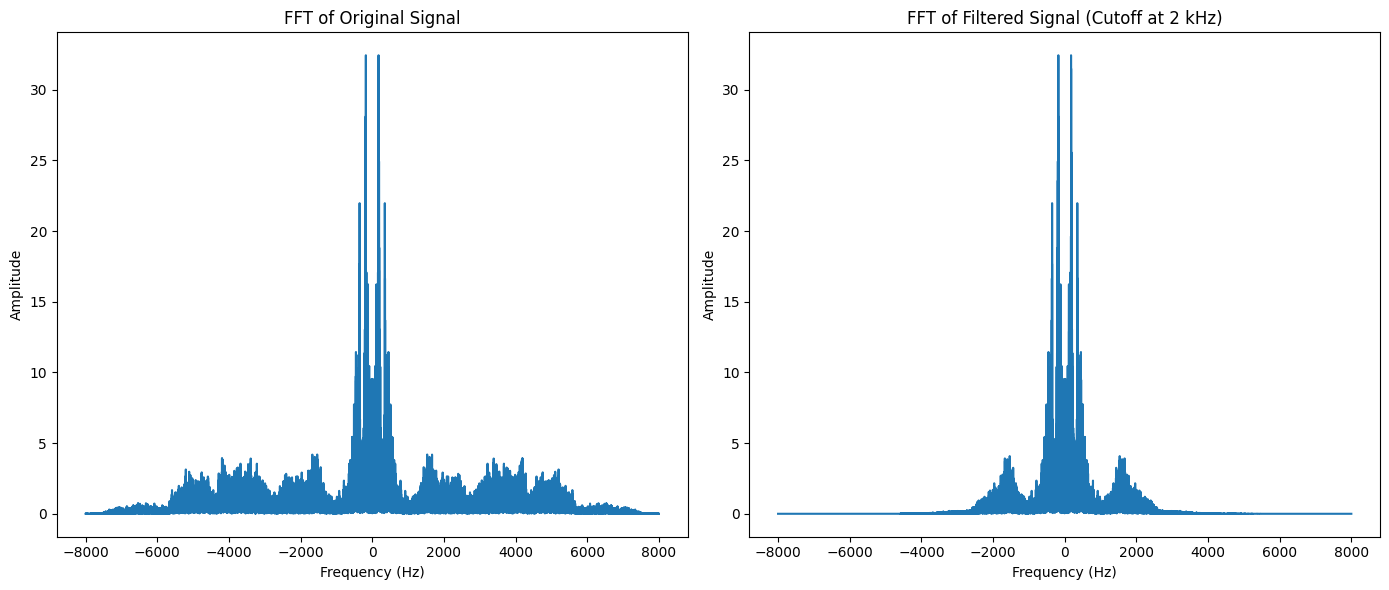

In [14]:
sampling_freq = 16000
cutoff_freq = 2000

# Butterworth low-pass filter
order = 5  
numerator_coeffs, denominator_coeffs = signal.butter(order, cutoff_freq, analog=False, fs=sampling_freq)

# Filter the signal
a_filtered = signal.lfilter(numerator_coeffs, denominator_coeffs, a)

# Plot the frequency content (FFT) before and after filtering
def plot_fft(signal, sampling_freq, title):
    l = len(signal)
    f = np.fft.fft(signal)
    f_shifted = np.fft.fftshift(f)  # Shift zero freq to center
    freqs = np.fft.fftshift(np.fft.fftfreq(l, 1/sampling_freq))
    
    plt.plot(freqs, np.abs(f_shifted)/l)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')

# FFT of original signal
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_fft(a, sampling_freq, 'FFT of Original Signal')

# FFT of filtered signal
plt.subplot(1, 2, 2)
plot_fft(a_filtered, sampling_freq, 'FFT of Filtered Signal (Cutoff at 2 kHz)')

plt.tight_layout()
plt.show()

Once the signal is filtered, we can downsample it (decimate) by taking every 4th sample. The anti-aliasing filter is already applied, so the decimation won’t introduce aliasing.

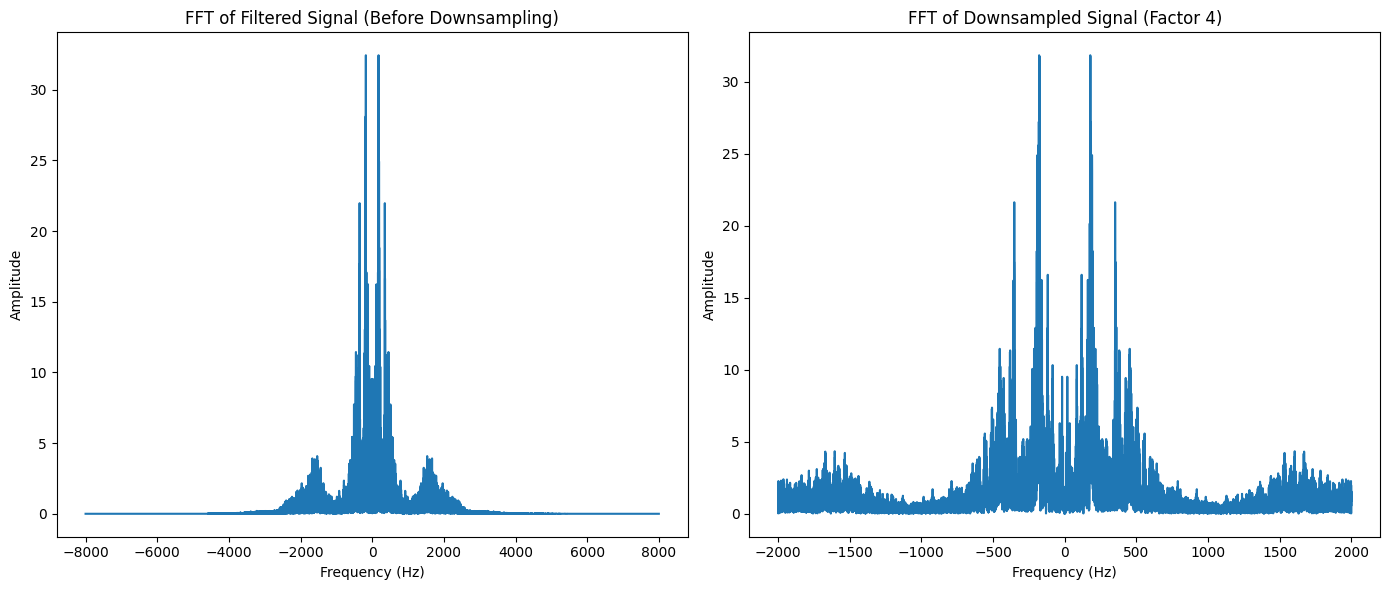

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Step 2: Downsample by a factor of 4 (keep every 4th sample)
downsampling_factor = 4
a_downsampled = a_filtered[::downsampling_factor]  # Keep every 4th sample

# New sampling frequency after downsampling
new_sampling_freq = sampling_freq // downsampling_factor

# Plot the frequency content (FFT) before and after downsampling
plt.figure(figsize=(14, 6))

# FFT of filtered signal (before downsampling)
plt.subplot(1, 2, 1)
plot_fft(a_filtered, sampling_freq, 'FFT of Filtered Signal (Before Downsampling)')

# FFT of downsampled signal
plt.subplot(1, 2, 2)
plot_fft(a_downsampled, new_sampling_freq, 'FFT of Downsampled Signal (Factor 4)')

plt.tight_layout()
plt.show()

### b)
Use Equation (1) above to reconstruct some values of the original signal, $x[n]$, that are not part of $x_{\rm{d}}[n]$, e.g. $x[4n+2]$. Of of course, you need to replace the infinite limits in the sum with finite ones. It is a good idea to take equally many on each side of the point of interest. Try briefly how many you seem to need for accurate results. You don't need to analyse this deeply. 
Compare the result to the correct values as well as the ones obtained by simple linear interpolation of the two surrounding points, i.e., 
\begin{equation}
\frac{x_{\rm{d}}[n] + x_{\rm{d}}[n+1]}{2}=\frac{x[4n] + x[4(n+1)]}{2}
\end{equation}.

## 3 (2p)
Show that a symmetric FIR filter with with odd number of real coefficients has linear phase. Here, antisymmetric means the filter coefficients fulfill 
\begin{equation}
h[N-n]=h[N+n]
\end{equation}
where $N$ and $n$ are postitive integers, $n\leq N$ and the filter has length $2N+1$. (See slides of lecture 4 for a figure.)

### Solution

A Finite Impulse Response (FIR) filter can be characterized by its impulse response $h[n]$. For a symmetric filter with a length of $2N + 1$ (an odd number of coefficients), the filter coefficients satisfy the following relation:

$ h[N - n] = h[N + n], \quad \text{for } n = 0, 1, 2, \dots, N $

This means the filter's coefficients are mirrored around the center at $N$.

To determine the phase of a given filter, we need to compute its frequency response. This can be achieved by applying the Discrete-Time Fourier Transform (DTFT) to the impulse response $h[n]$, yielding the following equation:

$ H(\omega) = \sum_{n=-\infty}^{\infty} h[n] e^{-j \omega n} $
 

Since our impulse response is finite, we can limit the summation to the range where $h[n]$ is non-zero. For a filter of length $2N + 1$, this gives:


$ H(\omega) = \sum_{n=0}^{2N} h[n] e^{-j \omega n} $
 

We can rewrite this sum as follows:

$ H(\omega) = h[N] e^{-j \omega N} + \sum_{n=1}^{N} h[N - n] e^{-j \omega (N - n)} +  h[N + n]e^{-j \omega (N + n)} $ 

Since the filter is symmetric, i.e., $h[N - n] = h[N + n]$, we can further simplify the equation:

$ H(\omega) = h[N] e^{-j \omega N} + \sum_{n=1}^{N} h[N - n] e^{-j \omega (N - n)} +  h[N - n]e^{-j \omega (N + n)} =  h[N] e^{-j \omega N} + \sum_{n=1}^{N} h[N - n] \left( e^{-j \omega (N - n)} + e^{-j \omega (N + n)} \right)$

Next, we simplify the complex exponentials:

$ e^{-j \omega (N - n)} + e^{-j \omega (N + n)} = e^{-j \omega N} e^{j \omega n} + e^{-j \omega N} e^{-j \omega n} = e^{-j \omega N} \left( e^{j \omega n} + e^{-j \omega n} \right) = e^{-j \omega N} \cdot 2 \cos(\omega n) $

Substituting this back into the previous expression, we get:

$ H(\omega) = h[N] e^{-j \omega N} + \sum_{n=1}^{N} h[N - n] e^{-j \omega N} \cdot 2 \cos(\omega n) $

Here, the term $e^{-j \omega N}$ can be factored out as it does not depend on $n$. Thus, we arrive at:

$ H(\omega) = e^{-j \omega N} \left( h[N] + 2 \sum_{n=1}^{N} h[N - n] \cos(\omega n) \right) $

In general, the frequency response of any filter can be expressed as:

$ H(\omega) = A(\omega) e^{j \phi(\omega)} $
 
where:

- $A(\omega)$ represents the magnitude of the frequency response
- $\phi(\omega)$ represents the phase of the frequency response


We can identify the components for our specific case:

- $ A(\omega) = h[N] + 2 \sum_{n=1}^{N} h[N - n] \cos(\omega n) $
- $ \phi(\omega) = -\omega N $

The $\phi(\omega)$ is a **linear function** of $\omega$, with a slope of $-N$.

Therefore, we have shown that a symmetric FIR filter with an odd number of coefficients has a linear phase.